# User Guide Follow-Along Code

This tutorial contains all the code used in the [Pyreal User Guides](https://dtail.gitbook.io/pyreal/user-guides/data-preparation-and-modelling). We recommend following along with the text there.

This tutorial uses a smaller version of the Ames Housing Dataset [1], with 8 key features selected. In this guide, we will train an ML model that predicts the sale price of houses based on these features. 

[1] De Cock, D. (2011). Ames, Iowa: Alternative to the Boston Housing Data as an End of Semester Regression Project. Journal of Statistics Education, 19(3). https://doi.org/10.1080/10691898.2011.11889627

# Data Preparation and Modelling
## Training and Input Data

Pyreal expects data in the format of Pandas DataFrames. Each row refers to one data instance (a person, place, thing, or entity), and each column refers to a feature, or piece of information about that instance. Column headers are the names of feature. Each instance may optionally have an instance ID, which can either be stored as the DataFrame's indices (row IDs) or as a separate column.

There are three categories of data relevant to ML decision-making: training data, testing data, and input data.
The training data is used to train the ML model and explainers. The testing data is used to evaluate the performance of the ML model (ie., how accurately it makes predictions). The input data is the data that you actively wish to get predictions on and understand better. 
For training and test data, we will usually have the ground truth values (the "correct" answer for the value your model tries to predict, often referred to as y-values) for all rows of data. 
For example, if we are trying to predict house prices, you would have additional information about the price of houses in your training/testing datasets. Pyreal expects these target values as pandas Series.

In the next cell we load in the training data from Pyreal's `sample_applicatons` module, split it into train and test sets using sklearn, and then inspect it.

In [1]:
import pandas as pd

from pyreal.sample_applications import ames_housing_small
from sklearn.model_selection import train_test_split

x, y = ames_housing_small.load_data(include_targets=True)
x_train, x_test, y_train, y_test = train_test_split(x, y)

x_train.head()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


,LotArea,Neighborhood,OverallQuality,YearBuilt,Material,BasementSize,CentralAir,HouseSize
898,12227.0,Northwest Ames,6.0,1977.0,Hard Board,1330.0,True,2872.0
88,7018.0,Sawyer West,5.0,1979.0,Hard Board,0.0,True,1535.0
200,9950.0,Northridge,7.0,1995.0,Vinyl Siding,NaN,True,2520.0
1363,9262.0,Somerset,8.0,2008.0,Cement Board,1573.0,True,1578.0
510,21872.0,Gilbert,7.0,NaN,Hard Board,729.0,True,1446.0


The training data is used to train the ML model and explainers. The input data is the data that you actively wish to get predictions on and understand better. The main difference between these two types is data is that you usually will have the ground truth values (the "correct" answer for the value your model tries to predict) for your training data but not your input data.

In the cell below, we inspect our ground-truth information for our training data, `y_train`, stored in a pandas Series.

In [2]:
y_train.head()

898     272000
88      118964
200     290000
1363    287090
510     175000
Name: SalePrice, dtype: int64

In the cell below, we load in and inspect out input data. For this data we have no ground truth values.

In [3]:
x_input = ames_housing_small.load_input_data()
x_input

,House ID,LotArea,Neighborhood,OverallQuality,YearBuilt,Material,BasementSize,CentralAir,HouseSize
0,House 101,9937,Edwards,5,1965,Hard Board,1256,True,1256
1,House 102,8450,College Creek,7,2003,Vinyl Siding,856,True,1710
2,House 103,9600,Veenker,6,1976,Metal Siding,1262,True,1262
3,House 104,11250,College Creek,7,2001,Vinyl Siding,920,True,1786
4,House 105,9550,Crawford,7,1915,Wood Siding,756,True,1717
5,House 106,14260,Northridge,8,2000,Vinyl Siding,1145,True,2198
6,House 107,14115,Mitchell,5,1993,Vinyl Siding,796,True,1362
7,House 108,10084,Somerset,8,2004,Vinyl Siding,1686,True,1694
8,House 109,10382,Northwest Ames,7,1973,Hard Board,1107,True,2090


## Transformers

Many ML models either require data to be in a specific format, or preform significantly better when data is a specific format. 
For example, many models require all data to be numeric, cannot handle missing data, or expect all features to be on similar numeric scales. But this is rarely the case in real-world applications, so we need to perform feature engineering using data transformers.

In the cell below, we initialize all the transformers we will need to make predictions with our model. See the [Pyreal User Guide](https://dtail.gitbook.io/pyreal/user-guides/data-preparation-and-modelling/transformers) for details.

We then fit the transformers to our training data, and inspect the resulting transformed data.

In [4]:
from pyreal.transformers import OneHotEncoder, MultiTypeImputer, StandardScaler, fit_transformers

oh_encoder = OneHotEncoder(columns=["Neighborhood", "Material"], handle_unknown="ignore")
imputer = MultiTypeImputer()
scaler = StandardScaler()

transformers = [oh_encoder, imputer, scaler]
fit_transformers(transformers, x_train).head()

,Neighborhood_Bloomington Heights,Neighborhood_Bluestem,Neighborhood_Briardale,Neighborhood_Brookside,Neighborhood_Clear Creek,Neighborhood_College Creek,Neighborhood_Crawford,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Iowa DOT and Rail Road,...,Material_Vinyl Siding,Material_Wood Shingles,Material_Wood Siding,Material_nan,LotArea,OverallQuality,YearBuilt,BasementSize,CentralAir,HouseSize
898,-0.121686,-0.044151,-0.104001,-0.206389,-0.144409,-0.328266,-0.187741,-0.26193,-0.233150,-0.170379,...,-0.721602,-0.117502,-0.4101,-0.213958,0.190983,-0.068527,0.208706,0.688676,0.264044,2.799322
88,-0.121686,-0.044151,-0.104001,-0.206389,-0.144409,-0.328266,-0.187741,-0.26193,-0.233150,-0.170379,...,-0.721602,-0.117502,-0.4101,-0.213958,-0.342057,-0.824661,0.275766,-2.617206,0.264044,0.071723
200,-0.121686,-0.044151,-0.104001,-0.206389,-0.144409,-0.328266,-0.187741,-0.26193,-0.233150,-0.170379,...,1.385805,-0.117502,-0.4101,-0.213958,-0.042024,0.687607,0.812243,0.000000,0.264044,2.081211
1363,-0.121686,-0.044151,-0.104001,-0.206389,-0.144409,-0.328266,-0.187741,-0.26193,-0.233150,-0.170379,...,-0.721602,-0.117502,-0.4101,-0.213958,-0.112427,1.443741,1.248130,1.292683,0.264044,0.159446
510,-0.121686,-0.044151,-0.104001,-0.206389,-0.144409,-0.328266,-0.187741,-0.26193,4.289082,-0.170379,...,-0.721602,-0.117502,-0.4101,-0.213958,1.177960,0.687607,0.000000,-0.805185,0.264044,-0.109845


## Modelling

We can now transform our training and testing data, and initialize, train, and evaluate our ML model.

In this guide, we will use LightGBM, a powerful and lightweight library that offers classfiers and regressors using the gradient boosting framework. 
It is an effective choice for many ML use cases.

In [5]:
from pyreal.transformers import run_transformers
from lightgbm import LGBMRegressor

x_train_model = run_transformers(transformers, x_train)
x_test_model = run_transformers(transformers, x_test)

model = LGBMRegressor().fit(x_train_model, y_train)

model.score(x_test_model, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 948
[LightGBM] [Info] Number of data points in the train set: 1028, number of used features: 32
[LightGBM] [Info] Start training from score 179158.704280


0.8374607563730473

# Creating New Applications (RealApps)

We can now combine the components we have created to create a new application, using the RealApp object. 
We set the ID column to "House ID", which is the column we use to ID our input data. We also pass in
a feature description dictionary, which converts our column names to more useful descriptions. Finally, 
we set a pred format functions to format the model predictions to dollar amounts.

In [6]:
from pyreal import RealApp

feature_descriptions = {'LotArea': 'Lot size in square feet', 
                        'Neighborhood': 'Neighborhood', 
                        'OverallQuality': 'Overall quality of the house finishing and materials (1-10)', 
                        'YearBuilt': 'Original construction date', 
                        'Material': 'Exterior material of house', 
                        'BasementSize': 'Total basement area in square feet', 
                        'CentralAir': 'Central air conditioning', 
                        'HouseSize': 'Total above ground living area in square feet'}

realapp = RealApp(model, 
                  X_train_orig=x_train, 
                  y_train=y_train, 
                  transformers=transformers,
                  id_column="House ID",
                  feature_descriptions=feature_descriptions,
                  pred_format_func=lambda x: f"${x:,.2f}")

#  Using Applications (RealApps)

Having created your RealApp, you can now use it to make predictions with and understand your ML model.

## Predictions
The most basic yet important functionality of an ML model is making predictions. For this, you can use the .predict() function. This function takes data in the original format, and then runs all transformers needed to prepare your input data for the model.

The output of the predict function is a dictionary with keys determined by the ID column. If not ID column is provided, the output is indexed by input index (row names).
This allows you to access predictions for specific instances by ID.

In [7]:
predictions = realapp.predict(x_input)

print(f"Predicted price for House 101: {predictions['House 101']}")

Predicted price for House 101: $137,625.71


## Explanations
Sometimes you may want more information about how an ML model came up with its prediction on an input. Or, you may have questions about the ML model in general.

For our example application of predicting house prices based on information about houses, you may have questions like:
1. What information about the house (or features) contributed to the prediction of $137,000?
2. Have we seen houses in the past similar to this one, and what were their prices?
3. What features, in general, does the model consider most important for predicting house prices?
4. How does the model use the "house size" feature? Are bigger houses always predicted to be more expensive?

### What features contributed to the model prediction?
To get a list of how much each feature in your input data contributed to the model's prediction, you can use the `.produce_feature_contributions(x_orig)` function.

Feature contribution outputs from RealApps are indexed by row ids, found in the column labelled by the optional id_column parameter to RealApps, or by the index (row labels) of the input data if no id column is provided. 
This allows us to access the explanation for a given house by ID:

In [8]:
contribution_scores = realapp.produce_feature_contributions(x_input, include_average_values=True)
contribution_scores["House 101"]

,Feature Name,Feature Value,Contribution,Average/Mode
0,Lot size in square feet,9937,593.842017,10360.666325
1,Overall quality of the house finishing and mat...,5,-21330.727026,6.090628
2,Original construction date,1965,-3412.415822,1970.77551
3,Total basement area in square feet,1256,3310.229282,1052.936656
4,Central air conditioning,True,732.023480,True
5,Total above ground living area in square feet,1256,-6773.117731,1499.843385
6,Exterior material of house,Hard Board,-155.178166,Vinyl Siding
7,Neighborhood,Edwards,-10968.037754,North Ames


If you are only interested in the most contributing features (either positively, negatively, or by absolute value), you can using the num_features and select_by parameters. Alternatively, you can extract the top contributing features from an already-generated explanation using the get_top_contributors function.

In [9]:
from pyreal.utils import get_top_contributors

# select_by is one of: "absolute", "min", "max"
top_contributions_for_house_101 = get_top_contributors(contribution_scores["House 101"], 
                                                       num_features=5, 
                                                       select_by="absolute")

# Or...
top_5_contribution_scores = realapp.produce_feature_contributions(x_input, 
                                                                  num_features=5,
                                                                  select_by="absolute")
top_5_contribution_scores["House 101"]

,Feature Name,Feature Value,Contribution
1,Overall quality of the house finishing and mat...,5,-21330.727026
7,Neighborhood,Edwards,-10968.037754
5,Total above ground living area in square feet,1256,-6773.117731
2,Original construction date,1965,-3412.415822
3,Total basement area in square feet,1256,3310.229282


### Which past cases are similar to this one?
You can get a list of past cases (rows of data in the training data) that are similar to your input data, as well as the ground-truth target (y) value for those cases, by using the produce_similiar_examples function:

In [10]:
# Get the three most similar houses from the 
# training dataset to each house in houses
similar_houses = realapp.produce_similar_examples(x_input, 
                                                  num_examples=3)

display(similar_houses["House 101"]["X"])
display(similar_houses["House 101"]["y"])

,Lot size in square feet,Neighborhood,Overall quality of the house finishing and materials (1-10),Original construction date,Exterior material of house,Total basement area in square feet,Central air conditioning,Total above ground living area in square feet
984,8562.0,Edwards,5.0,1957.0,Hard Board,1216.0,True,1526.0
1078,17755.0,Edwards,5.0,1959.0,Hard Board,1466.0,True,1466.0
534,11841.0,Edwards,6.0,1990.0,Hard Board,816.0,True,816.0


984     $144,500.00
1078    $149,900.00
534     $118,500.00
Name: SalePrice, dtype: object

### What features does the model consider most important in general?

You may be interested in understanding which features the model considers most important in general, without considering a specific input. For this, you can use the produce_feature_importance function, which takes no required inputs:

In [11]:
importance_scores = realapp.produce_feature_importance()

# Like with feature contributions, you can return only the most important features
#  or extract the most important features using `get_top_contributors`
top_5_importance_scores = realapp.produce_feature_importance(num_features=5)
top_5_importance_scores

,Feature Name,Importance
1,Overall quality of the house finishing and mat...,23362.854361
5,Total above ground living area in square feet,18465.401144
2,Original construction date,10520.600793
3,Total basement area in square feet,8990.224086
0,Lot size in square feet,6618.587123


### How does the model use a specific feature?
To understand how the model uses a specific feature, you can generate feature contributions for the full training dataset, and then investigate how the contributions vary for a specific feature by value.
To save time generating large numbers of contributions, and get the output in a more usable format for this specific use-case, you can set the format_output parameter to produce functions to False.

In [12]:
contribution_scores_df = realapp.produce_feature_contributions(x_input, format_output=False)

# explanation is now a tuple of (feature contributions, feature values), where
#  the column names are feature descriptions and the index are the row ids.

contributions, values = contribution_scores_df

# You can now investigate a single features contributions with:
pd.DataFrame({"Value of lot size feature": values["Lot size in square feet"], 
              "Contribution of lot size feature": contributions["Lot size in square feet"]})

,Value of lot size feature,Contribution of lot size feature
House ID,,
House 101,9937,593.842017
House 102,8450,60.103924
House 103,9600,2100.070431
House 104,11250,-610.737189
House 105,9550,-2839.755069
House 106,14260,19486.439872
House 107,14115,6546.040425
House 108,10084,-415.734045
House 109,10382,-3117.925987


## Visualization
Pyreal's visualize module includes several functions that take in RealApp output directly to generate explanation plots.

The feature bar plot can visualize general feature importance or feature contributions for a single input.

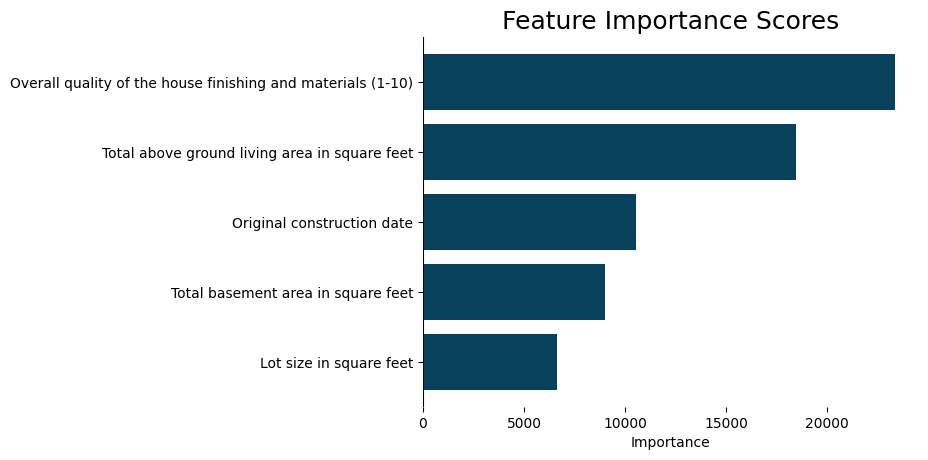

In [13]:
from pyreal.visualize import feature_bar_plot

feature_bar_plot(importance_scores)

For feature contribution explanations, the feature value is included in parentheses in the x-axis labels.

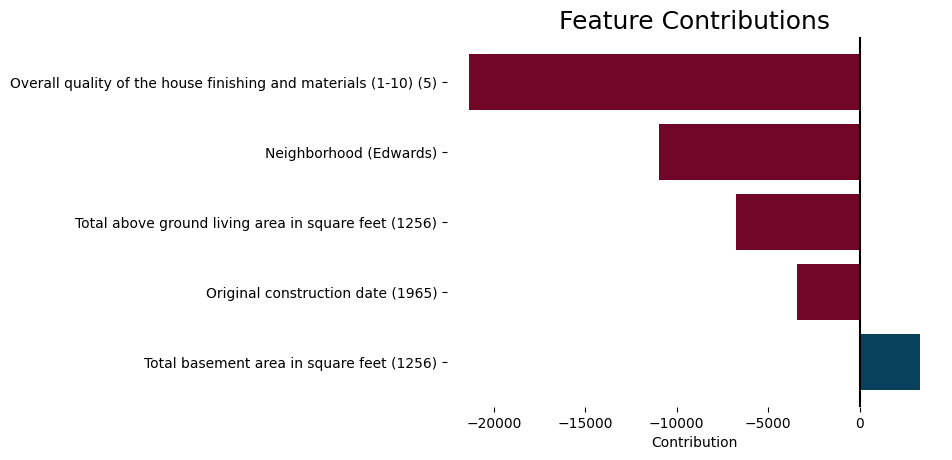

In [14]:
feature_bar_plot(contribution_scores["House 101"])

Strip plots are an effective way to visualize feature contributions for multiple inputs at a time, to understand the general trends of how the ML model uses features.

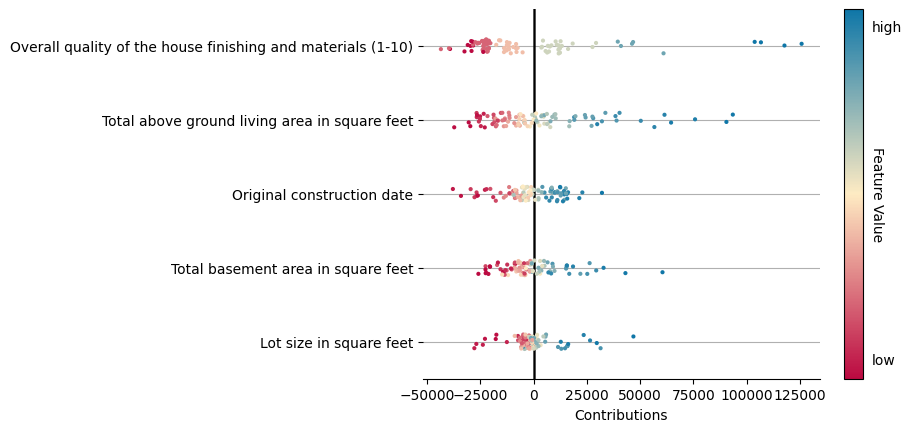

In [15]:
from pyreal.visualize import strip_plot

training_set_contributions = realapp.produce_feature_contributions(x_train.iloc[:100])
strip_plot(training_set_contributions)

Scatter plots allow you to investigate how the model uses a specific feature, across the full range of that feature's values:

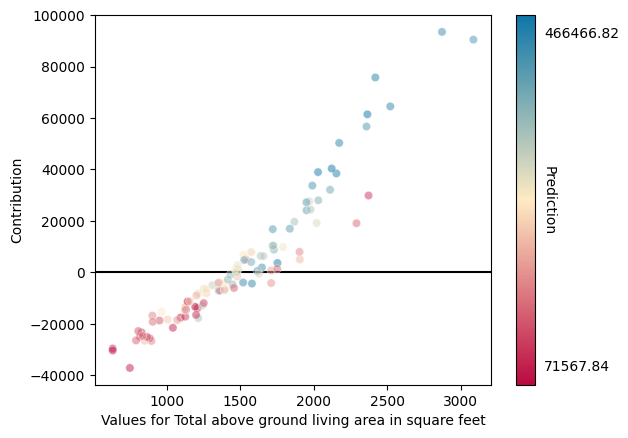

In [16]:
from pyreal.visualize import feature_scatter_plot

# Optionally pass in predictions to color the plot by prediction
predictions = realapp.predict(x_train.iloc[:100], format=False)

feature_scatter_plot(training_set_contributions, "Total above ground living area in square feet", predictions=predictions)

To get a clean table comparing the feature values of an input data row to those of similar examples, you can use the example_table function:

In [17]:
from pyreal.visualize import example_table

example_table(similar_houses["House 101"])

,Ground Truth,Lot size in square feet,Neighborhood,Overall quality of the house finishing and materials (1-10),Original construction date,Exterior material of house,Total basement area in square feet,Central air conditioning,Total above ground living area in square feet
Original Input,N/A,9937,Edwards,5,1965,Hard Board,1256,True,1256
984,"$144,500.00",8562.0,Edwards,5.0,1957.0,Hard Board,1216.0,True,1526.0
1078,"$149,900.00",17755.0,Edwards,5.0,1959.0,Hard Board,1466.0,True,1466.0
534,"$118,500.00",11841.0,Edwards,6.0,1990.0,Hard Board,816.0,True,816.0


## Narrative Explanations (Using LLMs)
You may prefer to get explanations in natural-language sentences. For example, instead of a table or graph of feature contributions, you may prefer what we call a *narrative explanation*.

To generate narrative explanations accurately, we plug the explanations generated by Pyreal into a large language model (LLM), which automatically converts it into sentence format.
Currently, Pyreal requires an OpenAI API key to use its narrative explanation functionality, which will incur a cost. 
To generate narrative explanations, you can either pass your API key to the RealApp object at initialization or with the `set_openai_client` function, or to the produce function. 

In [18]:
import yaml

# You can create your own keys.yml file with the line `openai_api_key: [your key]`
#   or manually set openai_api_key below
with open("keys.yml", "r") as file:
    config = yaml.safe_load(file)
    openai_api_key = config["openai_api_key"]

realapp.set_openai_client(openai_api_key=openai_api_key)
narratives = realapp.produce_narrative_feature_contributions(x_input)

narratives["House 101"]

'The model predicts a lower house price because the overall quality of the house is rated as 5, which has a significant negative impact. The neighborhood being Edwards also contributes negatively to the prediction. The size of the house and the year it was built both have negative effects on the price. However, having a basement size of 1256 square feet has a positive impact on the predicted price.'

You can train the LLM on what kinds of explanations you want. This is called few-shot learning. The LLM asks you for some examples of explanations, and then learns from those examples.
To run this training, you can use the .train_feature_contribution_llm. This function will show a few feature contributions explanations, and ask you for narrative versions using Python input/output.

In [19]:
# Set to True to run this cell
RUN_TRAINING = False

if RUN_TRAINING:
    realapp.train_feature_contribution_llm(num_inputs=2, num_features=2)
    narratives = realapp.produce_narrative_feature_contributions(x_input)
    
    # Explanations will now more closely match the examples you provided
    display(narratives["House 101"])